### Librerías requeridas

In [32]:
#!pip install skimage

In [33]:
#python and matplotlib libraries
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec

#machine learning libraries
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks

import cv2 as cv

### Importación de archivos

Imagenes/5m90/Eryx/DJI_0287.JPG


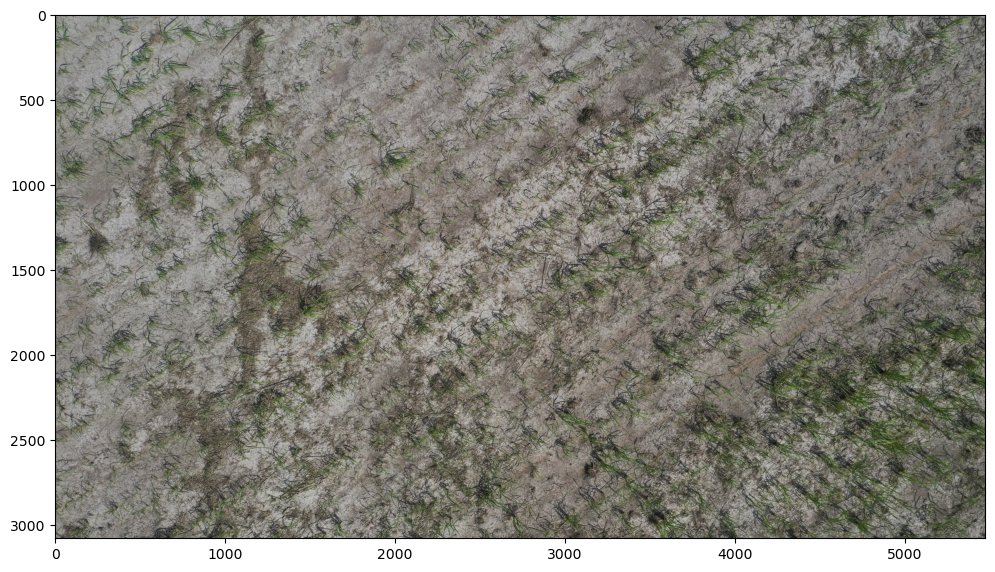

In [34]:
path = [
    '3m60/503_120_29.jpg', # Orientación horizontal
    '3m60/503_121_43.jpg',
    '3,5m90/503_119_43.jpg', # Orientación vertical
    '3m90/503_118_29.jpg',
    '3,5m90/209_101_24.jpg', # Etiquetada
    '3m60/209_416_15.jpg', # Etiquetada
    '5m90/Eryx/DJI_0287.JPG'
]

open = 'Imagenes/'+path[6]
print(open)
image = cv.imread(open)

im_color = cv.cvtColor(image, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12,8))
plt.imshow(im_color)
plt.show()
im = im_color

# EXPERIMENTOS
__*Método 0 - Umbral fijo (50): (ExG, Canny 2, Hough 2)*__

- 503_120_29 -> 17/17 lineas (100%)
- 503_121_43 -> 14/19 lineas (74%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 12/20 lineas (60%) _thresh 100_

__*Método 0 - Umbral fijo (50): (ExG, Canny 3, Hough 2)*__

- 503_120_29 -> 16/17 lineas (94%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 11/20 lineas (55%) thresh 100


__*Método 1 - OTSU: (ExG + Mask, Canny 2, Hough 2)*__

- 503_120_29 -> 14/17 lineas (82%)
- 503_121_43 -> 15/19 lineas (79%)
- 503_119_43 -> 19/24 lineas (79%)
- 209_206_54 -> 16/20 lineas (80%)

__*Método 3 - Percentiles: (ExG + Mask, Canny 2, Hough 2)*__

- 503_120_29 -> 14/17 lineas (82%)
- 503_121_43 -> 16/19 lineas (84%)
- 503_119_43 -> 21/24 lineas (88%)
- 209_206_54 -> 15/20 lineas (75%)

In [35]:
original = im_color
original.shape

(3078, 5472, 3)

In [36]:
# Dowscaling
#im_color = cv.pyrDown(im_color)
im_color.shape

(3078, 5472, 3)

## Pruebas con espacios de color

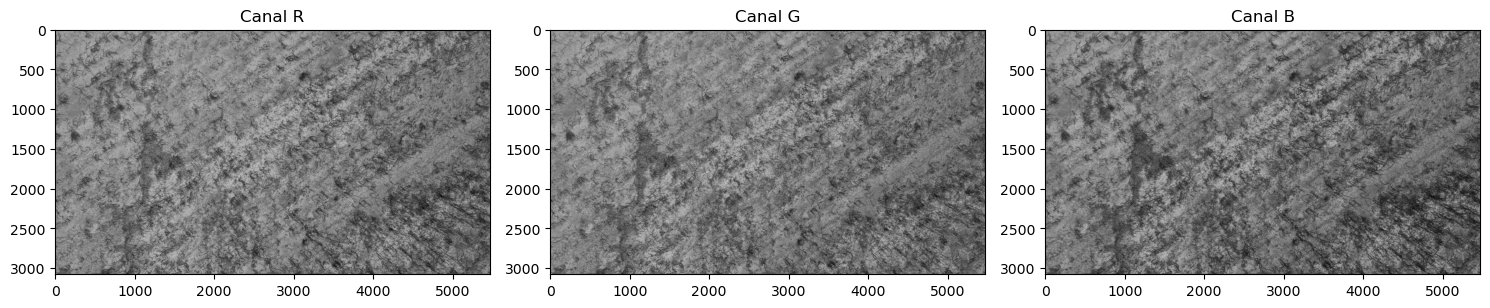

In [37]:
# Extraer los canales R, G, B
img_RGB = im_color
R, G, B = cv.split(img_RGB)

# Mostrar cada canal individual
fig = plt.figure(figsize=(15, 5))

ax1=plt.subplot(131)
ax1.imshow(R, vmin=0, vmax=255,cmap='gray')
ax1.set_title('Canal R')

ax2=plt.subplot(132)
ax2.imshow(G, vmin=0, vmax=255,cmap='gray')
ax2.set_title('Canal G')

ax3=plt.subplot(133)
ax3.imshow(B, vmin=0, vmax=255,cmap='gray')
ax3.set_title('Canal B')

plt.tight_layout()
plt.show()

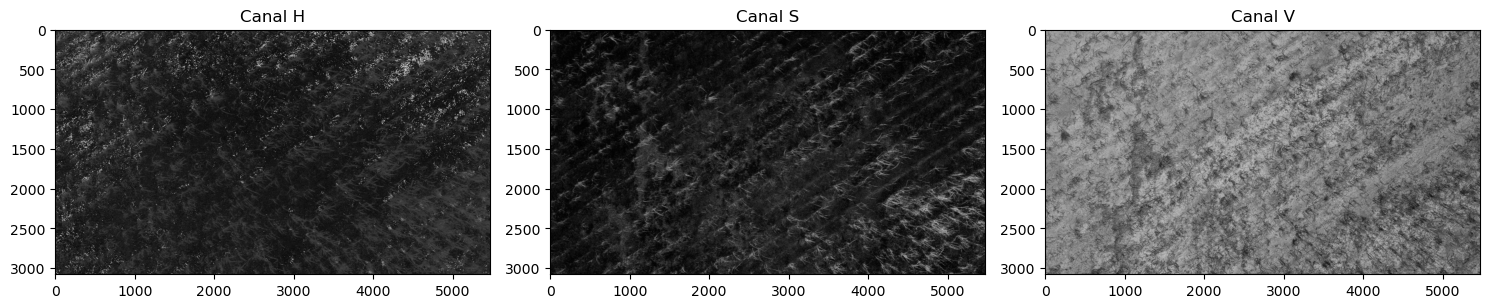

In [38]:
# Extraer los canales H, S, V
img_HSV = cv.cvtColor(im_color, cv.COLOR_RGB2HSV)
H, S, V = cv.split(img_HSV)

# Mostrar cada canal individual
fig = plt.figure(figsize=(15, 5))

ax1=plt.subplot(131)
ax1.imshow(H, vmin=0, vmax=179,cmap='gray')
ax1.set_title('Canal H')

ax2=plt.subplot(132)
ax2.imshow(S, vmin=0, vmax=255,cmap='gray')
ax2.set_title('Canal S')

ax3=plt.subplot(133)
ax3.imshow(V, vmin=0, vmax=255,cmap='gray')
ax3.set_title('Canal V')

plt.tight_layout()
plt.show()

**Posibles preprocesamiento de la imagen**

Reducción de ruido:
- Filtro Gaussiano: skimage.filters.gaussian
- Mediana: skimage.filters.median

Mejora de contraste:
- Equalización del histograma: skimage.exposure.equalize_hist.
- CLAHE (Contrast Limited Adaptive Histogram Equalization).


Umbral calculado basado en percentil (90): 89.0


(-0.5, 5471.5, 3077.5, -0.5)

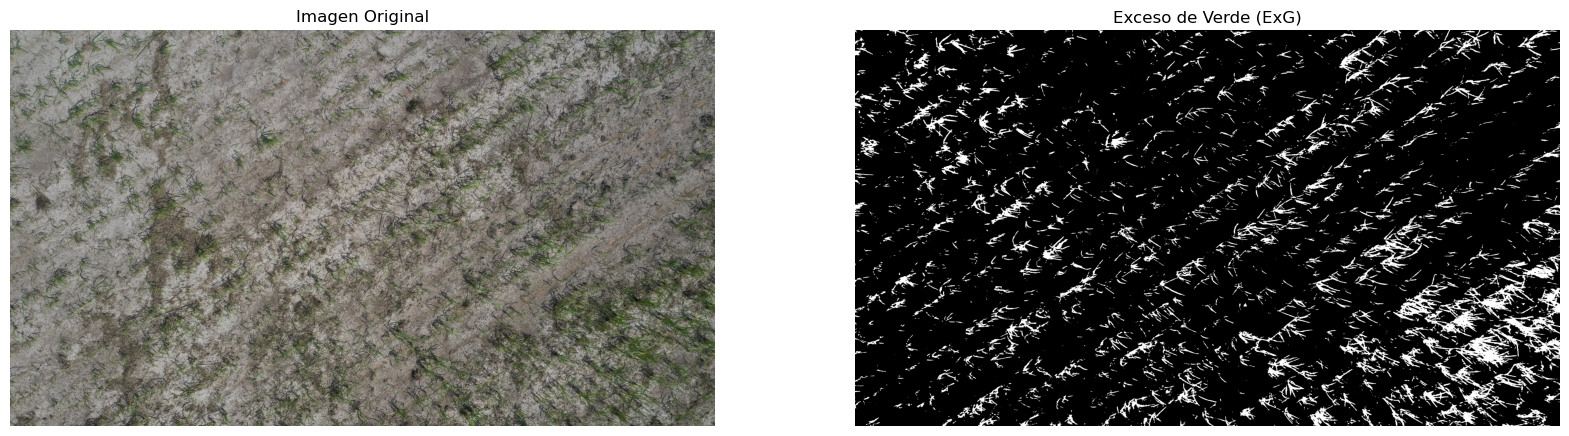

In [39]:

# Convertir a formato float para evitar problemas con saturación al realizar operaciones
image = im_color.astype('float32')
R, G, B = cv.split(image)

# Calcular el exceso de verde (ExG)
ExG = 2 * G - R - B

# Normalizar para visualizar (opcional, solo para visualización)
ExG_norm = cv.normalize(ExG, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX).astype('uint8')

method = 3 # Elegir método a aplicar
if method == 0:
    # Aplicar un umbral fijo
    threshold = 50 #umbral para Excess Green
    _, ExG_thresh = cv.threshold(ExG_norm, threshold, 255, cv.THRESH_BINARY)
elif method == 1:
    # Aplicar el método de Otsu
    _, ExG_thresh = cv.threshold(ExG_norm, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    print(f"Umbral calculado automáticamente por Otsu: {_: .2f}")
elif method == 2: # NO da buenos resultados
    # Umbralización adaptativa (celdas locales)
    ExG_thresh = cv.adaptiveThreshold(ExG_norm, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
elif method == 3:
    # Calcular umbral dinámico basado en percentiles
    percentile = 90
    threshold_value = np.percentile(ExG_norm, percentile)
    # Aplicar umbral
    _, ExG_thresh = cv.threshold(ExG_norm, threshold_value, 255, cv.THRESH_BINARY)
    print(f"Umbral calculado basado en percentil ({percentile}): {threshold_value}")
else:
    print("No se ha aplicado ningún umbral")

# Guardar como imagen
cv.imwrite('exg_result.png', ExG_thresh)

# Mostrar la imagen original y el resultado
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)
plt.imshow(image.astype('uint8'))
plt.title("Imagen Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ExG_thresh, cmap='gray')
plt.title("Exceso de Verde (ExG)")
plt.axis('off')

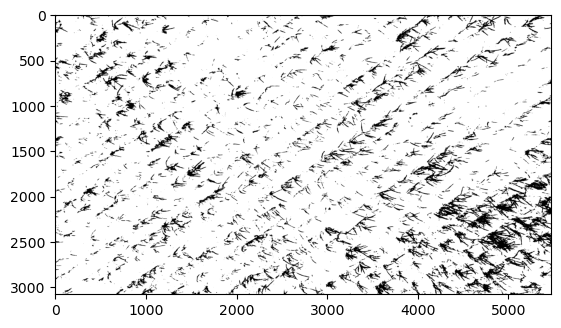

In [40]:
nExG = cv.bitwise_not(ExG_thresh)
plt.imshow(nExG, cmap='gray')

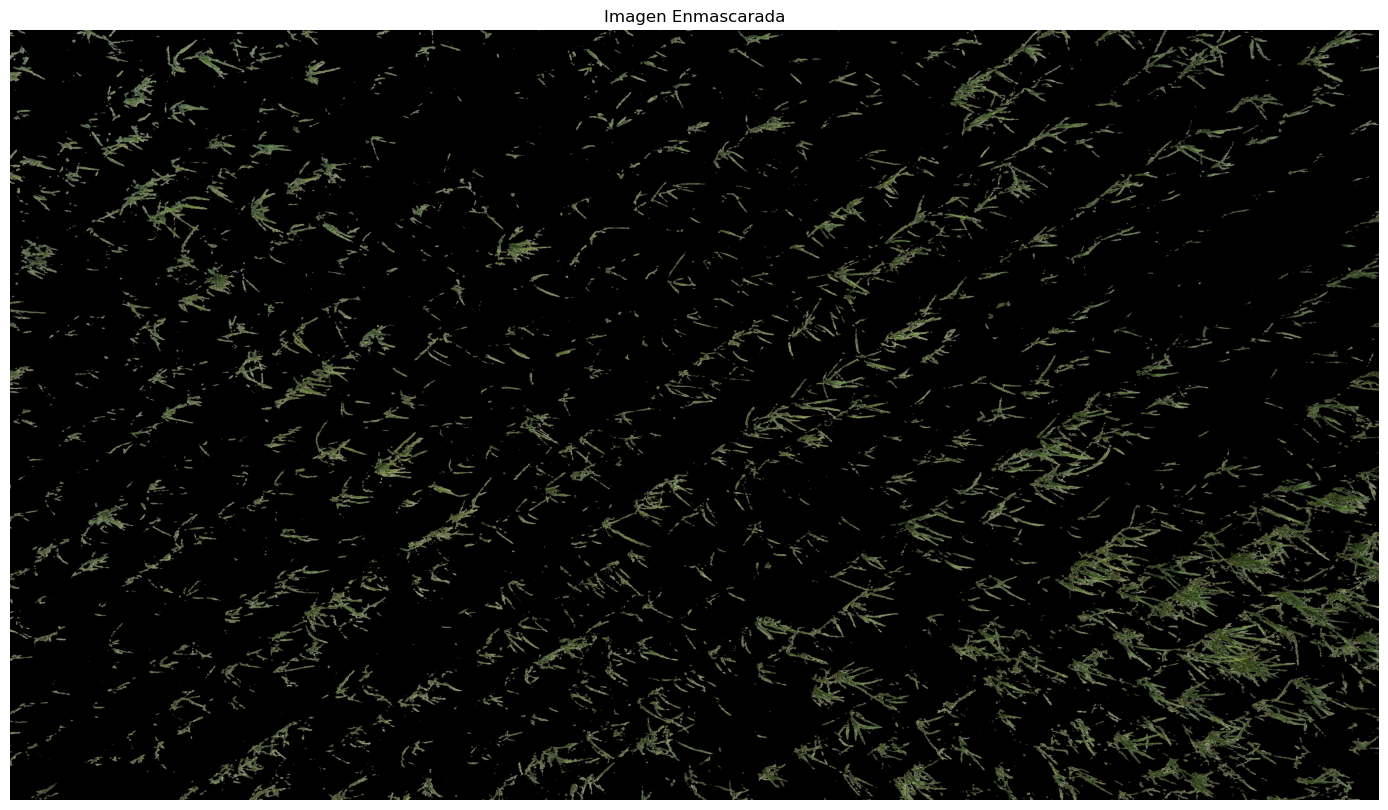

In [41]:
# Convertir la máscara a 3 canales para aplicarla a im_color
ExG_thresh_3ch = cv.merge([ExG_thresh, ExG_thresh, ExG_thresh])

# Aplicar la máscara sobre la imagen original
masked_image = cv.bitwise_and(im_color, ExG_thresh_3ch)

# Mostrar la imagen original, la máscara y la imagen enmascarada
plt.figure(figsize=(25, 10))
plt.plot()
plt.imshow(masked_image.astype('uint8'))
plt.title("Imagen Enmascarada")
plt.axis('off')

plt.show()

In [49]:
nExG

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [53]:
nExG[0][0]

255

In [54]:
masked_image[0][0]

array([0, 0, 0], dtype=uint8)

In [55]:
new_im = masked_image.copy()

for i, line in enumerate(nExG):
    print("Linea ", i)
    for j, pixel in enumerate(line):
        if pixel == 255:
            new_im[i][j] = [255, 255, 255]
            #print(pixel," - ", i, j)

Linea  0
Linea  1
Linea  2
Linea  3
Linea  4
Linea  5
Linea  6
Linea  7
Linea  8
Linea  9
Linea  10
Linea  11
Linea  12
Linea  13
Linea  14
Linea  15
Linea  16
Linea  17
Linea  18
Linea  19
Linea  20
Linea  21
Linea  22
Linea  23
Linea  24
Linea  25
Linea  26
Linea  27
Linea  28
Linea  29
Linea  30
Linea  31
Linea  32
Linea  33
Linea  34
Linea  35
Linea  36
Linea  37
Linea  38
Linea  39
Linea  40
Linea  41
Linea  42
Linea  43
Linea  44
Linea  45
Linea  46
Linea  47
Linea  48
Linea  49
Linea  50
Linea  51
Linea  52
Linea  53
Linea  54
Linea  55
Linea  56
Linea  57
Linea  58
Linea  59
Linea  60
Linea  61
Linea  62
Linea  63
Linea  64
Linea  65
Linea  66
Linea  67
Linea  68
Linea  69
Linea  70
Linea  71
Linea  72
Linea  73
Linea  74
Linea  75
Linea  76
Linea  77
Linea  78
Linea  79
Linea  80
Linea  81
Linea  82
Linea  83
Linea  84
Linea  85
Linea  86
Linea  87
Linea  88
Linea  89
Linea  90
Linea  91
Linea  92
Linea  93
Linea  94
Linea  95
Linea  96
Linea  97
Linea  98
Linea  99
Linea  100

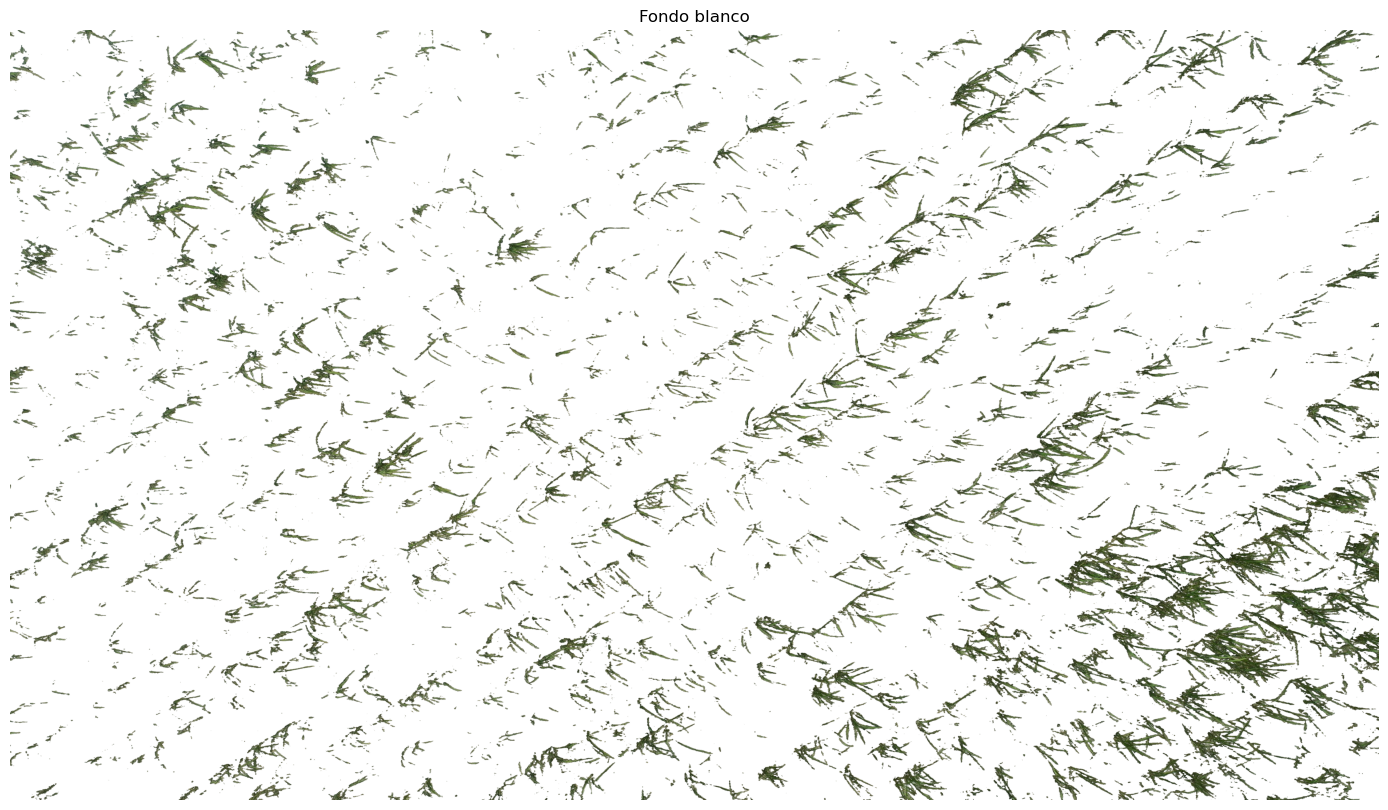

In [56]:
# Mostrar la imagen original, la máscara y la imagen enmascarada
plt.figure(figsize=(25, 10))
plt.plot()
plt.imshow(new_im.astype('uint8'))
plt.title("Fondo blanco")
plt.axis('off')

plt.show()

In [63]:
im = ExG_thresh.copy()
# masked_image
# ExG_thresh
# Si genera error de dimension (imagen color)
# im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)